### features:
* selected spectogram coef
* zero crossing rate
* selected chromogram values
* selected tempogram values
* wavelet of level 0

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
import itertools

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
csv_path = "/Users/ecem/Desktop/csv of scgs"
wavelet_csv = "/Users/ecem/Desktop/wavelet-csv"

## Load data

Here, our target is to predict disease correctly. So; our y will be disease column of  dataset

In [3]:
spec = pd.read_csv(csv_path + '/p-value-selected-intersection-spec.csv', index_col = 0)
#spec  #uncomment to see dataframe

signal_proc = pd.read_csv(csv_path + '/signal_processing.csv', index_col = 0)
y = signal_proc.disease

zero_crossing = signal_proc.iloc[:,:21]
#zero_crossing #uncomment to see dataframe

tempogram = pd.read_csv(csv_path + '/p-value-selected-tempogram.csv', index_col = 0)
#tempogram #uncomment to see dataframe

chromogram = pd.read_csv(csv_path + '/p-value-selected-chromogram.csv', index_col = 0)
#chromogram #uncomment to see dataframe

w_lvl0 = pd.read_csv(wavelet_csv + '/wavelet_lvl0.csv', index_col = 0).drop(['disease'], axis =1)
w_lvl0  #uncomment to see dataframe

,lvl0_x0,lvl0_x1,lvl0_x2,lvl0_x3,lvl0_x4,lvl0_x5,lvl0_x6,lvl0_x7,lvl0_x8,lvl0_x9,...,lvl0_z38,lvl0_z39,lvl0_z40,lvl0_z41,lvl0_z42,lvl0_z43,lvl0_z44,lvl0_z45,lvl0_z46,lvl0_z47
0,-0.503078,-0.508493,-0.495124,-0.461686,-0.327573,-0.463505,-0.319357,-0.290070,-0.372214,-0.670804,...,-0.004803,-0.009975,-0.013297,0.031506,0.034660,0.121152,0.158909,0.128339,0.134332,0.149062
1,-0.337088,-0.358658,-0.344212,-0.297174,-0.193528,-0.346729,-0.177544,-0.201896,-0.263341,-0.287319,...,-0.056027,-0.044484,-0.025730,0.040819,-0.007631,-0.004883,-0.056402,-0.067213,-0.057641,-0.039950
2,-0.382271,-0.409044,-0.397055,-0.353910,-0.297396,-0.389712,-0.234055,-0.194504,-0.231223,-0.298895,...,0.017353,0.029110,0.004084,-0.041428,-0.044852,-0.034972,0.053526,0.039660,0.035398,0.031143
3,0.071162,0.089320,0.064081,-0.037265,-0.353574,-0.289820,-0.397483,-0.365879,-0.382827,-0.204690,...,0.052188,-0.078633,-0.044265,-0.024217,-0.029692,0.051737,0.043672,0.048377,0.047015,0.038573
4,-0.790181,-0.790978,-0.778167,-0.723883,-0.509830,-0.586515,-0.283325,-0.336158,-0.268263,-0.318504,...,-0.014478,0.017597,-0.019702,-0.037006,0.019880,0.066369,0.091973,0.078102,0.079841,0.083903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,0.254162,0.256369,0.261570,0.288534,0.391812,0.492755,0.414114,0.194791,-0.130332,-0.118806,...,0.014821,0.009703,0.038727,0.016893,0.051154,0.023889,0.014518,0.018233,0.018315,0.018180
1458,0.349622,0.321284,0.310296,0.278119,0.003263,-0.149820,-0.205826,-0.210372,-0.252378,-0.305266,...,0.006079,-0.028282,-0.056236,-0.020658,-0.042306,-0.025261,0.045890,0.026822,0.025429,0.030637
1459,-0.163857,-0.138495,-0.157529,-0.233442,-0.414839,-0.340551,-0.398183,-0.368650,-0.085265,0.094994,...,-0.026788,-0.088121,-0.051529,-0.048913,-0.070555,-0.049824,-0.080925,-0.069791,-0.070239,-0.077539
1460,-0.383882,-0.363848,-0.364389,-0.366114,-0.272939,0.017750,0.177799,0.347536,0.578930,0.653146,...,-0.055060,-0.042704,-0.035764,-0.022767,0.005606,0.042350,0.034094,0.036432,0.035644,0.033274


In [4]:
features = pd.concat([spec, w_lvl0], axis = 1)
features = pd.concat([features, zero_crossing], axis = 1)
features = pd.concat([features, chromogram], axis = 1)
features = pd.concat([features, tempogram], axis = 1)

#features

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([2, 2, 2, ..., 1, 1, 1])

In [6]:
list(le.classes_)

['AR', 'AS', 'MR', 'MS']

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(features, y_encoded, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [8]:
import xgboost as xgb
model  = xgb.XGBClassifier(random_state = 42, objective='multi:softprob', eval_metric = 'merror') 

# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [9]:
predictions = model.predict(X_valid)

In [10]:
classes = ['AR', 'AS', 'MR', 'MS']

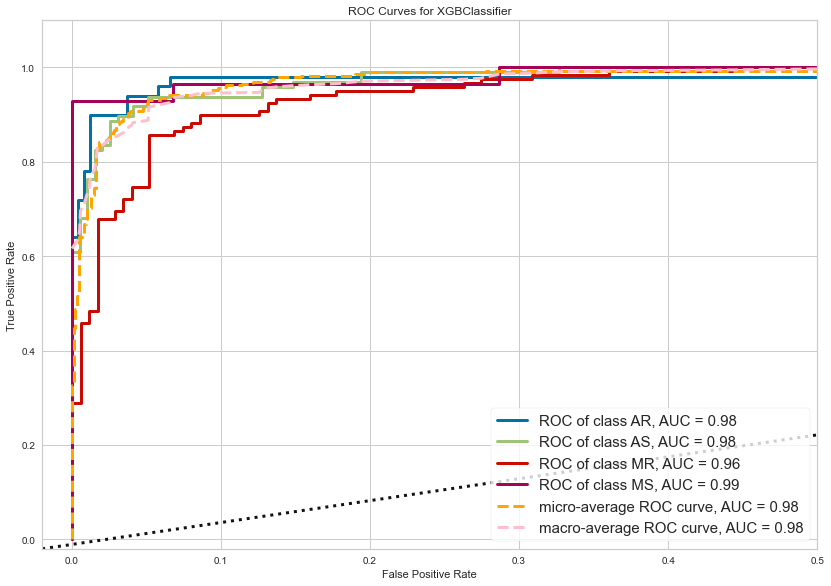

In [11]:
rocauc = ROCAUC(model, size=(1000, 700), classes=classes)

rocauc.fit(X_train, y_train)       
rocauc.score(X_valid, y_valid)  
r = rocauc.poof()

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


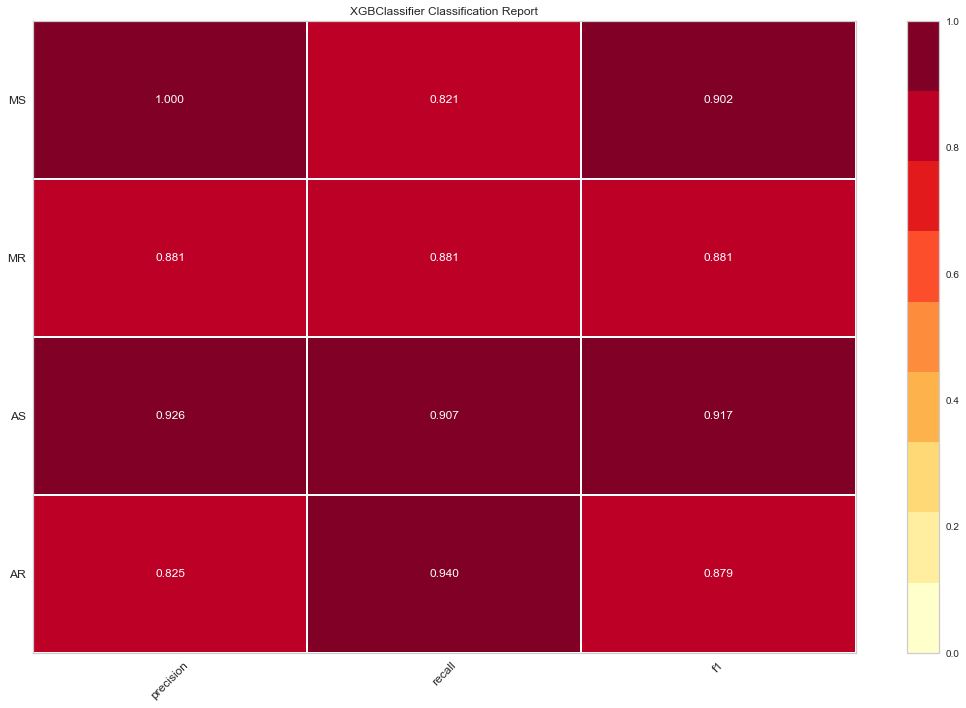

In [12]:
report = ClassificationReport(model, size=(1080, 720), classes=classes)

report.score(X_valid, y_valid)
c = report.poof()

In [13]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid, predictions)
print("accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y_valid, predictions, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y_valid, predictions, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

accuracy: 89.42%
recall: 89.42%
precision: 89.79%


In [14]:
class_names = ['AR', 'AS', 'MR', 'MS']

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


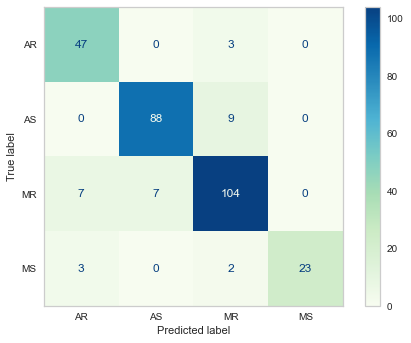

In [15]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_valid, y_valid, display_labels= ['AR', 'AS', 'MR', 'MS'], cmap = 'GnBu')  
plt.grid(None)
plt.show()

### with 0.01 variation

In [16]:
vt = VarianceThreshold(threshold = 0.0001)

In [17]:
_ = vt.fit(features)
masked = vt.get_support()
features_masked = features.loc[:, masked]
features_masked # uncomment to see the dataframe

,freq_z1926,freq_x1927,freq_y1939,freq_z1939,freq_y1927,freq_z1927,freq_x563,freq_y563,freq_z563,freq_x564,...,A♯_z,C_y,C♯_y,C♯_z,D_x,D_y,A_x,tempogram_x256,tempogram_y256,tempogram_z255
0,0.002497,0.002424,0.004543,0.004615,0.002366,0.002334,0.001880,0.001847,0.001862,0.001916,...,0.855271,0.762100,0.725288,0.676100,0.622803,0.687656,0.544785,0.561135,0.530600,0.655776
1,0.002897,0.002712,0.004400,0.004647,0.002609,0.002596,0.002336,0.002379,0.002457,0.002558,...,0.938481,0.664045,0.576668,0.579724,0.703581,0.754574,0.601679,0.558041,0.500824,0.698621
2,0.002414,0.002365,0.005216,0.005540,0.002328,0.002317,0.002529,0.002579,0.002619,0.002633,...,0.913051,0.697642,0.663615,0.639449,0.574114,0.618220,0.524400,0.628894,0.625713,0.723520
3,0.002438,0.002572,0.005091,0.005287,0.002719,0.002850,0.002740,0.002799,0.002833,0.002833,...,0.848634,0.654161,0.672035,0.603927,0.589418,0.613129,0.535861,0.558907,0.529697,0.683446
4,0.002391,0.002288,0.004506,0.004486,0.002205,0.002143,0.002170,0.002145,0.002131,0.002139,...,0.837774,0.727435,0.682958,0.580415,0.660723,0.626793,0.405941,0.620978,0.598515,0.721680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,0.003207,0.003096,0.004052,0.004192,0.002999,0.002910,0.001752,0.001815,0.001869,0.001918,...,0.995025,0.561606,0.672115,0.630791,0.697209,0.764679,0.678021,0.659751,0.641036,0.750267
1458,0.003426,0.003498,0.003287,0.003204,0.003577,0.003671,0.002414,0.002425,0.002417,0.002395,...,0.866784,0.542422,0.667886,0.631187,0.667806,0.800844,0.841114,0.773952,0.787490,0.826712
1459,0.002653,0.002648,0.003926,0.003852,0.002632,0.002611,0.002127,0.002121,0.002115,0.002108,...,0.491950,0.572536,0.566397,0.667347,0.786895,0.853182,0.452119,0.918128,0.932019,0.942913
1460,0.002904,0.003001,0.003369,0.003337,0.003076,0.003128,0.001754,0.001852,0.001950,0.002046,...,0.403071,0.472331,0.499508,0.587656,0.701192,0.734620,0.956889,0.866317,0.863513,0.910716


In [18]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features_masked, y_encoded, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [19]:
import xgboost as xgb
model_  = xgb.XGBClassifier(random_state = 42, eval_metric = 'merror', objective='multi:softprob' ) 

# Fit the model
model_.fit(X_train_, y_train_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [20]:
predictions_ = model_.predict(X_valid_)

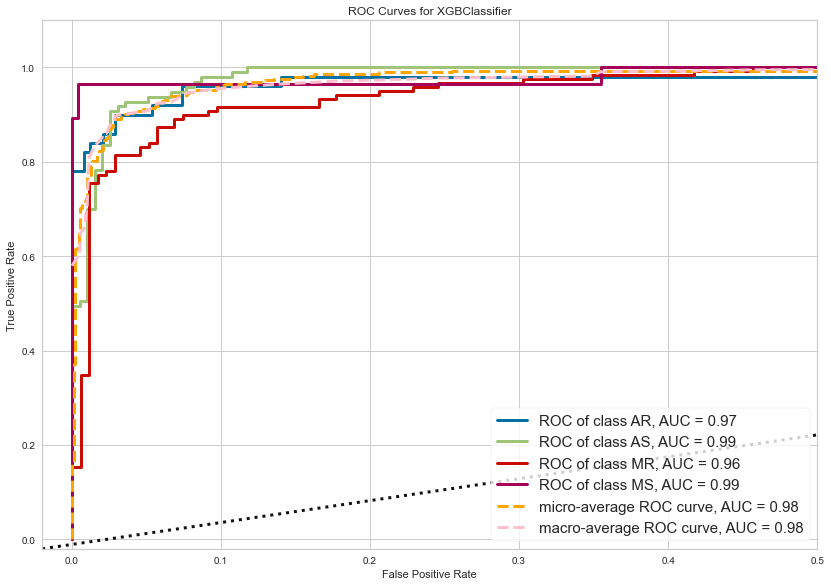

In [21]:
rocauc_ = ROCAUC(model_, size=(1000, 700), classes=classes)

rocauc_.fit(X_train_, y_train_)       
rocauc_.score(X_valid_, y_valid_)  
r = rocauc_.poof()

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


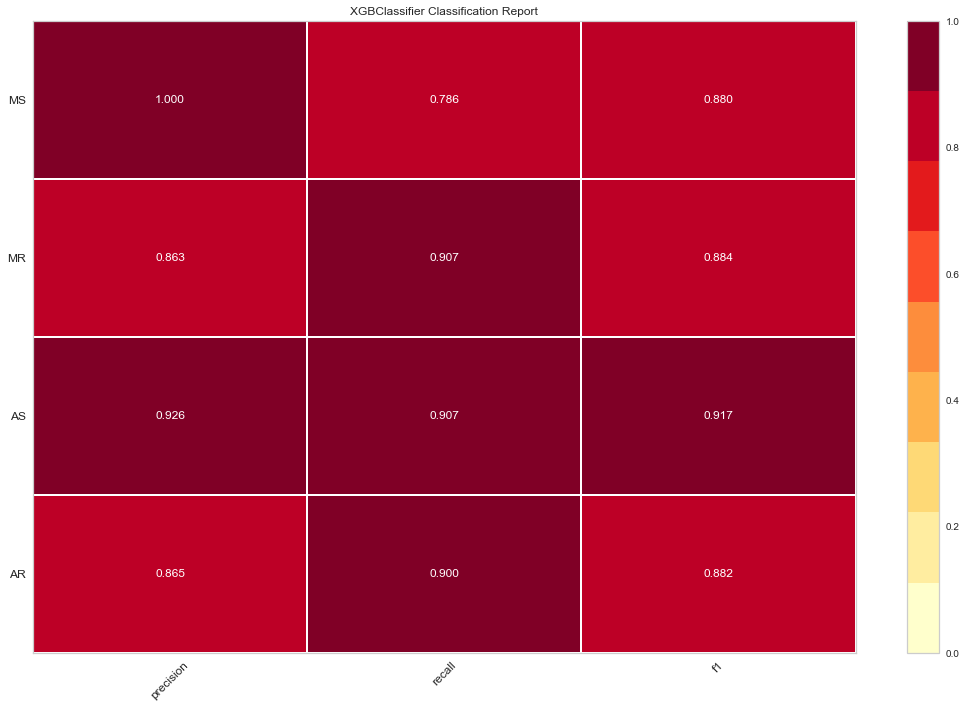

In [22]:
report_ = ClassificationReport(model_, size=(1080, 720), classes=classes)

report_.score(X_valid_, y_valid_)
c = report_.poof()

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid_, predictions_)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.42%


In [24]:
recall = recall_score(y_valid_, predictions_, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y_valid_, predictions_, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

recall: 89.42%
precision: 89.74%


/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


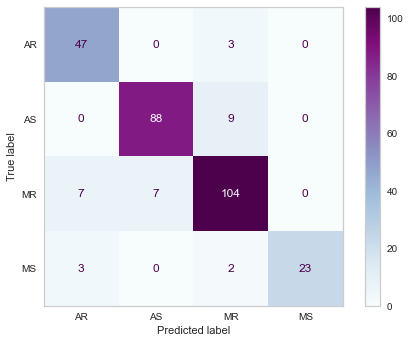

In [25]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_valid, y_valid, display_labels= ['AR', 'AS', 'MR', 'MS'], cmap = 'BuPu')  
plt.grid(None)
plt.show()

[12:48:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1662013895516/work/src/learner.cc:627: 
Parameters: { "learing_rate", "n_estiamtors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 89.42%
recall: 89.42%
precision: 89.74%


/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


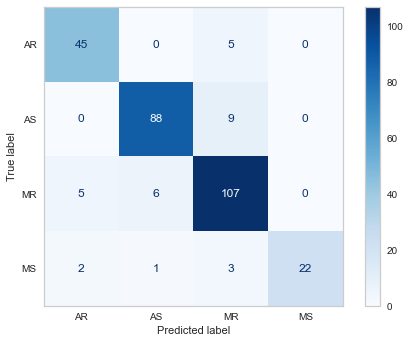

In [26]:
model_gs = xgb.XGBClassifier( learing_rate =  0.1,  max_depth= 6, n_estiamtors = 500,
                             min_child_weight=  1, eval_metric = 'merror', objective='multi:softprob' ) 

# Fit the model
model_gs.fit(X_train_, y_train_)

predictions_gs = model_gs.predict(X_valid_)
accuracy_gs = accuracy_score(y_valid_, predictions_gs)
print("Accuracy: %.2f%%" % (accuracy_gs * 100.0))

recall_gs = recall_score(y_valid_, predictions_gs, average= 'weighted')
print("recall: %.2f%%" % (recall_gs * 100.0))

precision_gs = precision_score(y_valid_, predictions_gs, average= 'weighted')
print("precision: %.2f%%" % (precision_gs * 100.0))

plot_confusion_matrix(model_gs, X_valid_, y_valid_, display_labels= ['AR', 'AS', 'MR', 'MS'],  cmap="Blues") 
plt.grid(None)
plt.show()

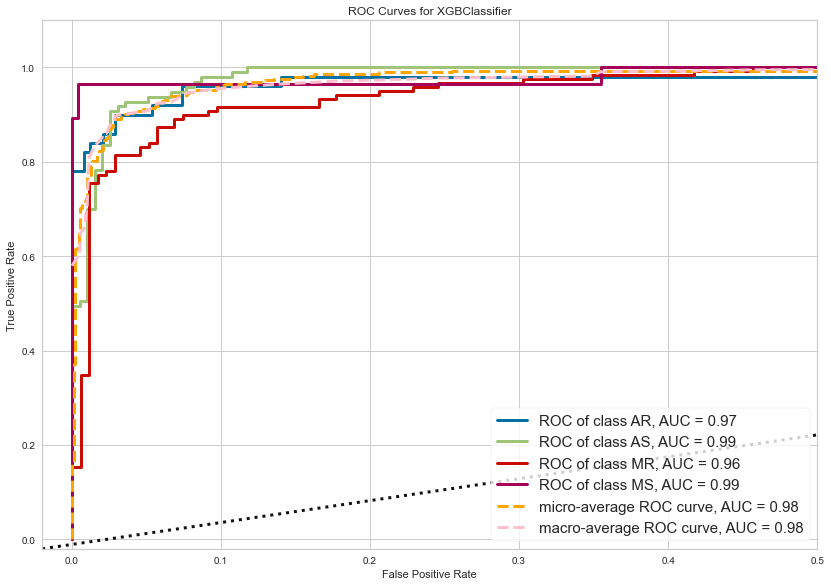

In [27]:
rocauc_gs = ROCAUC(model_gs, size=(1000, 700), classes=classes)

rocauc_gs.fit(X_train_, y_train_)       
rocauc_gs.score(X_valid_, y_valid_)  
r_gs = rocauc_gs.poof()

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


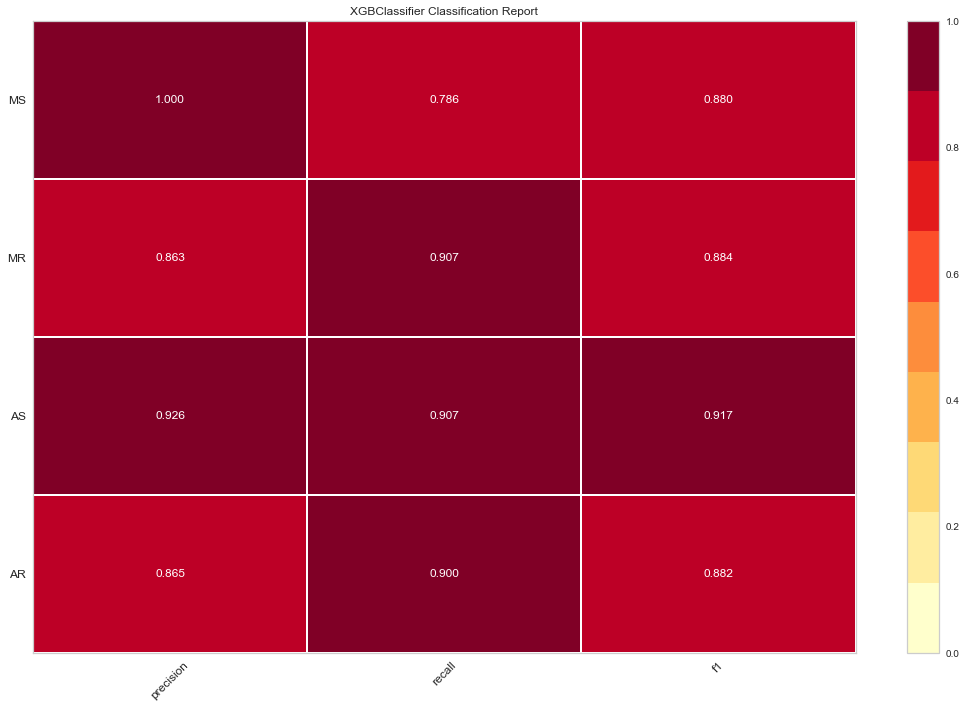

In [28]:
report_gs = ClassificationReport(model_gs, size=(1080, 720), classes=classes)

report_gs.score(X_valid_, y_valid_)
c_gs = report_gs.poof()